# Tensor images
This notebook gives an overview of the concept of tensor images, and demonstrates how to use this feature.

In [1]:
import diplib as dip

# let's keep the images small
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 72

DIPlib -- a quantitative image analysis library
Version 3.5.1 (Sep  5 2024)
For more information see https://diplib.org


After reading the "*PyDIP* basics" notebook, you should be familiar with the concepts of scalar images and color images. We remind the reader that an image can have any number of values associated to each pixel. An image with a single value per pixel is a scalar image. Multiple values can be arranged in one or two dimensions, as a vector image or a matrix image. A color image is an example of a vector image, for example in the RGB color space the vector for each pixel has 3 values, it is a 3D vector.

The generalization of vectors and matrices is a tensor. A rank 0 tensor is a scalar, a rank 1 tensor is a vector, and a rank 2 tensor is a matrix.

## Some example tensor images

This is a scalar image:

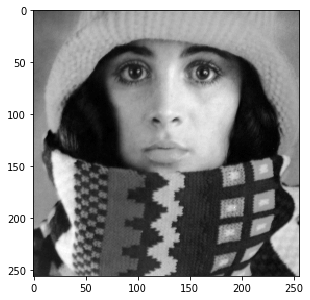

In [2]:
img = dip.ImageRead('trui.ics')
img.Show()

We can compute its gradient, which is a vector image: 

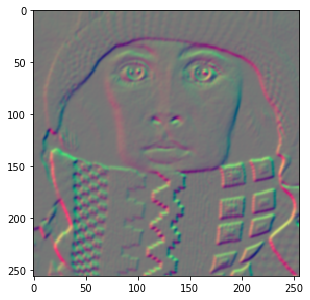

In [3]:
g = dip.Gradient(img)
g.Show()

The vector image is displayed by showing the first vector component in the red channel, and the second one in the green channel. `g` has two components:

In [4]:
print(g.TensorElements())

2


In [5]:
print(g.TensorShape())

column vector


Note that the image itself is not a matrix or a tensor. An image can be seen as a multi-dimensional array, but we don't apply matrix multiplication or other linear algebra on the image as a matrix. But each pixel can be a matrix, or a vector, and we can apply linear algebra on the pixels.

Multiplying a vector image with its transposed leads to a symmetric matrix:

In [6]:
S = g @ dip.Transpose(g)
print(S.__repr__())

<Tensor image (2x2 symmetric matrix, 3 elements), SFLOAT, sizes {256, 256}>


Note how the 2x2 symmetric matrix stores only 3 elements per pixel. Because of the symmetry, the `[0,1]` and the `[1,0]` elements are identical, and need not be both stored. See [the documentation](https://diplib.org/diplib-docs/dip-Tensor.html#dip-Tensor-Shape) for details on how the individual elements are stored.

Note also that the transposed image is not an image with spatial axes swapped, we transpose the vector or matrix at each pixel.

Local averaging of this matrix image (i.e. applying a low-pass filter) leads to the structure tensor:

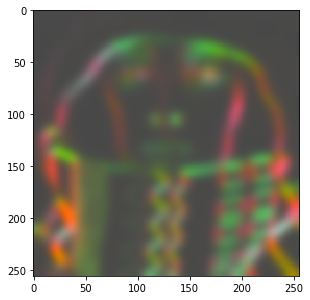

In [7]:
dip.Gauss(S, out=S, sigmas=5)
S.Show()

We can still display this tensor image, because it has only 3 tensor elements, which can be mapped to the three RGB channels of the display.

The structure tensor is one of the more important applications for the concept of the tensor image. In [this documentation page](https://diplib.org/diplib-docs/why_tensors.html) there are some example applications of the structure tensor. Here we show how to get the local orientation from it using the eigenvalue decomposition.

In [8]:
eigenvalues, eigenvectors = dip.EigenDecomposition(S)
print(eigenvalues.TensorShape())
print(eigenvectors.TensorShape())

diagonal matrix
column-major matrix


The eigendecomposition is such that `S @ eigenvectors == eigenvectors @ eigenvalues`. `eigenvectors` is a full 2x2 matrix, and hence has 4 tensor elements. These are stored in column-major order. The first column is the eigenvector that corresponds to the first eigenvalue. Eigenvalues are sorted in descending order, and hence the first eigenvector is perpendicular to the edges in the image.

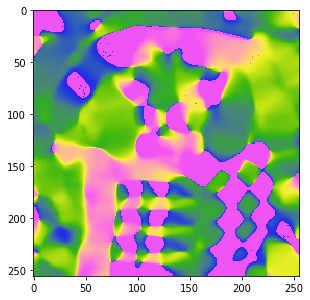

In [9]:
v1 = eigenvectors.TensorColumn(0)
angle = dip.Angle(v1)
angle.Show('orientation')

Note that extracting a column from the tensor yields a vector image, and that this vector image shares data with the column-major matrix image. Transposing a matrix is a cheap operation that just changes the storage order of the matrix, without a need to copy or reorder the data:

In [10]:
tmp = dip.Transpose(eigenvectors)
print(tmp.TensorShape())
print(tmp.SharesData(eigenvectors))

row-major matrix
True


A second important matrix image is the Hessian matrix, which contains all second order derivatives. Just like the strucutre tensor, it is a symmetric 2x2 matrix:

<Tensor image (2x2 symmetric matrix, 3 elements), SFLOAT, sizes {256, 256}>


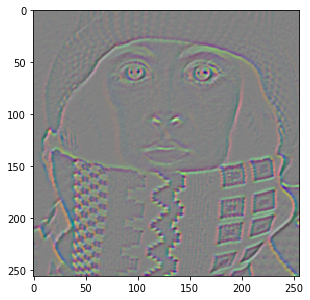

In [11]:
H = dip.Hessian(img)
print(H.__repr__())
H.Show()

## Arithmetic with tensor images
We've already seen the matrix multiplication `@`. Other arithmetic operators are always applied on a per-sample basis: addition `+` and subtraction `-`, multiplication `*`, division `/` and remainder `%`, exponentiation `**`, bit-wise operators `&`, `|`, `^`, and comparison operators `==`, `!=`, `>`, `>=`, `<`, and `<=`.

In [12]:
res = S / S
print(res.__repr__())

<Tensor image (2x2 symmetric matrix, 3 elements), SFLOAT, sizes {256, 256}>


Note how dividing `S` by itself yields a tensor image of the same sizes and shapes as `S`. Each sample in the left-hand size is divided by the corresponding sample in the right-hand side.

In [13]:
res = S / eigenvectors
print(res.__repr__())

<Tensor image (2x2 column-major matrix, 4 elements), SFLOAT, sizes {256, 256}>


In this case, `S` has only 3 tensor elements, whereas `eigenvectors` has 4. But they both represent a 2x2 matrix, which match up. The result is a full 2x2 matrix (4 tensor elements).

Let's try to divide a 2x2 matrix image by a column vector image. These don't match up, so an exception is raised.

In [14]:
try:
    res = S / eigenvectors.TensorColumn(0)
except Exception as e:
    print(f"\033[31m{type(e).__name__} exception:", str(e).split('\n')[0])

ParameterError exception: Number of tensor elements doesn't match


There is no broadcasting (or singleton expansion as it's called in the *DIPlib* documentation) for tensor elements, unless one of the images is a scalar.

In [15]:
res = S / eigenvectors(0)
print(res.__repr__())

<Tensor image (2x2 symmetric matrix, 3 elements), SFLOAT, sizes {256, 256}>


Broadcasting is, however, applied to the spatial dimensions as you'd expect.

Oftentimes, one needs to use a single pixel as one of the operands. For example to add the same value to each pixel in the image. We can of course use a scalar value:

In [16]:
res = g + 5
print(res.__repr__())

<Tensor image (2x1 column vector, 2 elements), DFLOAT, sizes {256, 256}>


To create a column vector pixel, simply provide a list:

In [17]:
res = g + [1, 5]
print(res.__repr__())

<Tensor image (2x1 column vector, 2 elements), DFLOAT, sizes {256, 256}>


Because the `+` operator works element-wise, a row vector and a column vector can be added together:

In [18]:
res = dip.Transpose(g) + [1, 5]
print(res.__repr__())

<Tensor image (1x2 row vector, 2 elements), DFLOAT, sizes {256, 256}>


But if one needs a matrix, or a row tensor like the example below, it is a bit more complex to create.

In [19]:
res = dip.Transpose(g) @ [1, 5]
print(res.__repr__())

<Scalar image, DFLOAT, sizes {256, 256}>


In [20]:
try:
    res = g @ [[1, 5]]
except Exception as e:
    print(f"\033[31m{type(e).__name__} exception:", str(e).split('\n')[0])

RunTimeError exception: Cannot convert input to dip::Image


A *NumPy* array is interpreted as an image, not as a tensor pixel, so cannot be used either.

In [21]:
import numpy as np
try:
    res = g @ np.array([[1, 5]])
except Exception as e:
    print(f"\033[31m{type(e).__name__} exception:", str(e).split('\n')[0])

ParameterError exception: Sizes don't match


Instead, use the `dip.Create0D()` function:

In [22]:
p = dip.Create0D([1, 5])
p.Transpose()
print(p.__repr__())

<Tensor image (1x2 row vector, 2 elements), SINT64, 0D>


In [23]:
res = dip.Create0D(np.array([[1, 5]]))
print(res.__repr__())

<Tensor image (1x2 row vector, 2 elements), SINT64, 0D>


In [24]:
res = g @ dip.Transpose(dip.Create0D([1, 5]))
print(res.__repr__())

<Tensor image (2x2 column-major matrix, 4 elements), DFLOAT, sizes {256, 256}>


To create a special tensor shape, you can use `dip.Image.ReshapeTensor()`:

In [25]:
p = dip.Create0D([1.4, 0.5, -1.0])
p.ReshapeTensor(dip.Tensor("symmetric matrix", 2, 2))
print(p.__repr__())

<Tensor image (2x2 symmetric matrix, 3 elements), DFLOAT, 0D>
